In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten

Using TensorFlow backend.


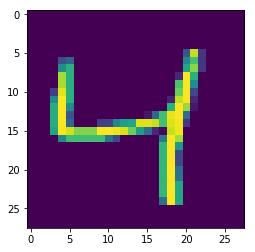

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[2].reshape(28,28))

In [14]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# One hot encoding
y_train = keras.utils.to_categorical(y_train,10)
y_test = keras.utils.to_categorical(y_test,10)

In [15]:
# Build the model
model = Sequential()
# 28*28*1
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',activation='relu'))#,input_shape=(28,28,1))) # kernel_size tells the window size(filter size)
# 28*28*64
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
# 14*14*64
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
# 14*14*64
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.25))
# 7*7*64
model.add(Flatten())
# 3036*1024
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.25))
# 1024*10
model.add(Dense(units=10,activation='softmax'))

In [16]:
# Train the model
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
# AdaDelta is a adaptive gradient descent algorithm
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 306s 5ms/step - loss: 0.1230 - acc: 0.9610 - val_loss: 0.0348 - val_acc: 0.9872
Epoch 2/5
60000/60000 [==============================] - 328s 5ms/step - loss: 0.0433 - acc: 0.9859 - val_loss: 0.0251 - val_acc: 0.9910
Epoch 3/5
60000/60000 [==============================] - 288s 5ms/step - loss: 0.0327 - acc: 0.9893 - val_loss: 0.0206 - val_acc: 0.9932
Epoch 4/5
60000/60000 [==============================] - 281s 5ms/step - loss: 0.0274 - acc: 0.9915 - val_loss: 0.0217 - val_acc: 0.9918
Epoch 5/5
60000/60000 [==============================] - 267s 4ms/step - loss: 0.0213 - acc: 0.9935 - val_loss: 0.0223 - val_acc: 0.9930


In [27]:
import tensorflow as tf
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [28]:
MODEL_NAME = 'mnist_convnet'

In [31]:
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

export_model(tf.train.Saver(), model, ["conv2d_1_input"], "dense_2/Softmax")

INFO:tensorflow:Restoring parameters from out/mnist_convnet.chkp
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
graph saved!


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              3212288   
__________